## Packages 

In [115]:
# import packages
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf

import descarteslabs as dl
import descarteslabs.workflows as wf
import utils_santo 
import importlib
import tifffile
import imagecodecs

from utils_santo import gdal_dataset_from_geocontext
from unet import UNet
from PIL import Image
from shapely.geometry import shape
from osgeo import gdal, ogr
from typing import Sequence

## Import GeoJSON

In [97]:
with open("/home/jovyan/gtc-exposure/change_detection/ratio_attempt/dominicaDamage.geojson") as f:
    fc = json.load(f)

In [98]:
a_map = wf.interactive.MapApp()
a_map.center = (15.3050, -61.3787)
a_map.zoom = 15

los_plat_geojson = ipyleaflet.GeoJSON(data=fc,
                   style={"color": "red", "fillOpacity": 0.1},
                   hover_style={"fillOpacity": 0.1})

a_map.add_layer(los_plat_geojson)

img = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2020-12-20', end_datetime='2020-12-22').pick_bands("red green blue") #start_datetime='2020-11-24', end_datetime='2020-12-01'
my_mosaic = img.max(axis="images")
my_mosaic.visualize('image', scales=[(0, 1), (0, 1), (0, 1)], map=a_map)

a_map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## Generate Training Data from Polygons

In [30]:
def generate_tiff_from_polygons(
    polygons,
    products,
    bands,
    resolution,
    tilesize,
    pad,
    start_datetime,
    end_datetime,
    out_folder,
    seed=0,
    debugging = False
    ):
    if isinstance(polygons, str):
        fname = polygons
        with open(fname) as f:
            poly = json.load(f)
        polygons = {"type": "FeatureCollection", "features": poly["features"]}
        ogr_ds = ogr.Open(fname)
    elif isinstance(polygons, dict):
        assert polygons["type"] == "FeatureCollection"
        ogr_ds = ogr.Open(json.dumps(polygons))
    else:
        print("Wrong datatype for POLYGONS.")
        return 0
    n_features = len(polygons["features"])

    layer = ogr_ds.GetLayer()
    
    #Bounding box covering all the polygons
    poly_coords = []
    for i in range(n_features):
        poly_coords.extend(polygons['features'][i]['geometry']['coordinates'][0])
        
        
    min_corner = [min(map(lambda x:x[0], poly_coords)), min(map(lambda x:x[1], poly_coords))]
    max_corner = [max(map(lambda x:x[0], poly_coords)), max(map(lambda x:x[1], poly_coords))]
    
    #Turn this into a polygon
    aoi_feature = {
        "type":"Polygon",
        "coordinates":[[
            min_corner,
            [min_corner[0], max_corner[1]],
            max_corner,
            [max_corner[0], min_corner[1]],
            min_corner
        ]]
    }  

    #Get dltiles for bounding box around geojsons
    dltiles = dl.scenes.DLTile.from_shape(shape = aoi_feature, resolution = resolution, tilesize = tilesize, pad = pad)
    
    arrs = []
    trgts = []
    
    #Normalisation for spectral bands for the given product. ASSUMES THEY ARE ALL ON THE SAME SCALE
    product_bands = list(dl.catalog.Product.get(products).bands())
    
    max_spectral_val = -1
    for band in product_bands:
        if band.type == 'spectral':
            max_spectral_val = band.data_range[1]
            break
    
    if max_spectral_val == -1:
        print("Could not find maximum spectral value for bands in product")
        return
    
    for i, dltile in enumerate(dltiles):
        savefile_image = out_folder + "{}.tiff".format("image_"+str(i))
        savefile_target = out_folder + "{}.tiff".format("target_"+str(i))
        
        # Search for scenes for the dltile
        scenes, ctx = dl.scenes.search(
            aoi=dltile,
            products=products,
            start_datetime=start_datetime,
            end_datetime=end_datetime,
        )
        
        #Break if no valid scene for this dltile
        if len(scenes) == 0:
            break
            
        #Get the raster image for these scenes - i.e the satellite data in the given bands
        arr = scenes.mosaic(bands=bands, ctx=ctx, bands_axis=-1) #* 255 / max_spectral_val
        #n.b you can plot this using plt.imshow(arr.data)
        arr = np.ma.MaskedArray.astype(np.rint(arr/max_spectral_val * 255), np.uint8)
        tifffile.imsave(savefile_image, arr, planarconfig="contig")
        #image = Image.fromarray(arr)
        #image.save(savefile_image)
        
        # Using the metadata get the target - the map of whether the settlements are informal or not
        ds_target = gdal_dataset_from_geocontext(
            ctx,
            1,
            driver_name="GTiff",
            savename=savefile_target,
            dtype="byte",
            options=["COMPRESS=LZW"],
        )
        
        gdal.RasterizeLayer(
            ds_target,
            [1],
            layer,
            burn_values=[1],
            options=["ALL_TOUCHED=TRUE", "COMPRESS=LZW"],
        )

        del ds_target

        
        
        if debugging:
            arrs.append(arr)
            img_target = np.array(Image.open(savefile_target))
            trgts.append(img_target)
            #Again can be viewed with plt.imshow(img_target)
        
 
        

    if debugging: 
        return arrs, trgts
    else:
        return

In [61]:
generate_tiff_from_polygons('/home/jovyan/gtc-exposure/change_detection/ratio_attempt/dominicaDamage.geojson',
                products='sentinel-2:L1C',
                bands=['red'],#, 'green', 'blue', 'red-edge', 'red-edge-2', 'red-edge-3', 'red-edge-4', 'nir', 'swir1', 'swir2'],
                resolution=10,
                tilesize=64,
                pad=0,
                start_datetime='2017-10-01',
                end_datetime='2017-11-01',
                out_folder='classifier_data/',
                )

## How to load and show a target .tiff file

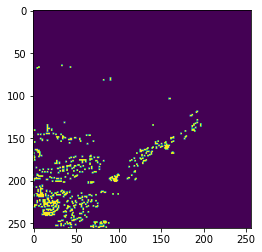

In [105]:
a_target = Image.open('/home/jovyan/OSCD/new/roseau/target_3.tiff') #tifffile complains about codecs if you try to use that here
#target_pixel_data = np.reshape(list(a_target.getdata()), (64,64))
plt.imshow(a_target)

(256, 256, 10)
(471, 525)


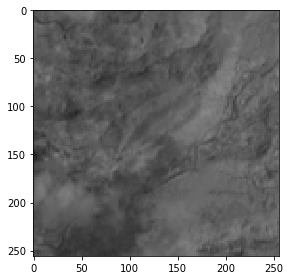

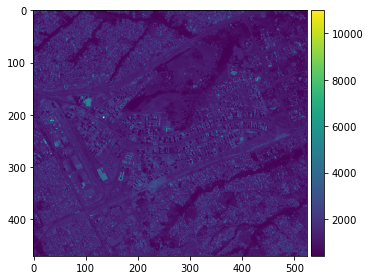

In [114]:
from skimage import io
targ = io.imread('/home/jovyan/OSCD/new/roseau/image_3.tiff')

#targ = targ.reshape(64,64)
print(targ.shape)
io.imshow(targ[:,:,6])

plt.figure()
onera = io.imread('./classifier_data/S2A_OPER_MSI_L1C_TL_EPA__20161227T091305_A001222_T22LHH_B04.tif')
onera = onera.reshape(onera.shape[0],onera.shape[1])
print(onera.shape)
io.imshow(onera)

## How to load and show an image .tiff file
You can do it directly from PIL.Image instead but it doesn't work very well for the target file because it's binary instead of 0-255

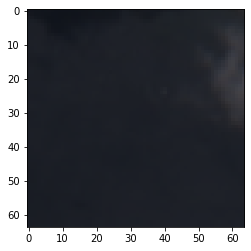

In [27]:
a_image = tifffile.imread("classifier_data/image_4.tiff")
image_pixel_data = a_image[:,:,0:3] #RGB Selected as bands 1:3
plt.imshow(image_pixel_data)

## Run the cell bellow to generate & plot the training examples for the geojsons specified in the top line

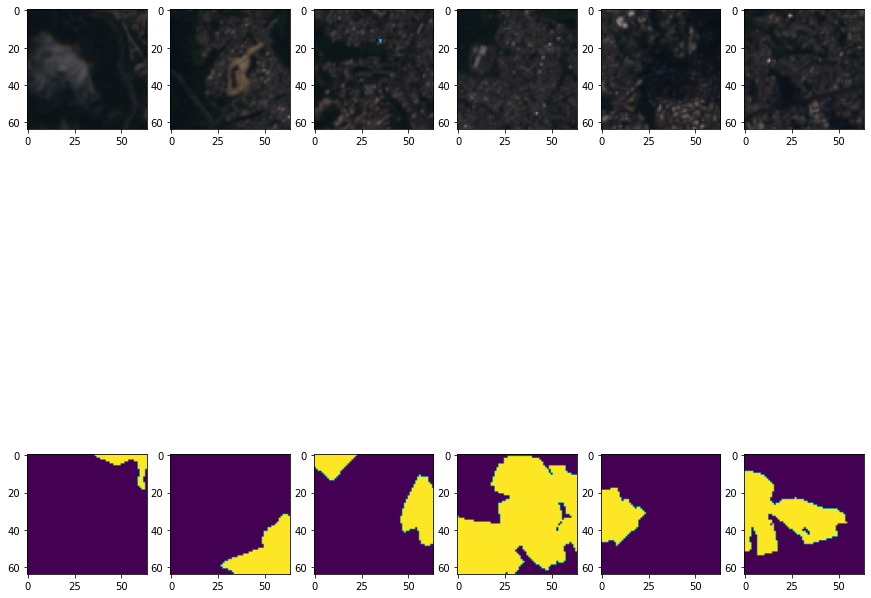

In [50]:
arrs, trgts = generate_tiff_from_polygons('santo_domingo_north.geojson',
                products='sentinel-2:L1C',
                bands=['red', 'green', 'blue'],
                resolution=10,
                tilesize=64,
                pad=0,
                start_datetime='2020-12-20',
                end_datetime='2020-12-22',
                out_folder='classifier_data/',
                debugging = True)

fig, ax = plt.subplots(2,6)

fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(6):
    ax[0,i].imshow(arrs[i])
    ax[1,i].imshow(trgts[i])
    
#Note - can't get rid of the enormous spacing between the plots.